In [1]:
import csv
import cv2
import numpy as np
import sklearn
from random import shuffle

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
samples = []

# Load Sample Training Data, 8000+ images
with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# Load New Training Data, 4000+ inmages, 2 laps of Tracks 1 in clockwise direction and 2 laps of Tracks 1 in counter-clockwise direction
with open('../new/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples[1:], test_size=0.3)

In [3]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                # create adjusted steering measurements for the side camera images
                correction = 0.2 # this is a parameter to tune
                angle = [float(batch_sample[3])]
                angle.append(angle[0] + correction)
                angle.append(angle[0] - correction)
                
                # read in images from center, left and right cameras
                for i in range(3):
                    name = '../data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)                    
                    images.append(image)
                    angles.append(angle[i])
                    images.append(np.fliplr(image))
                    angles.append(-angle[i])

            # add images and angles to data set
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [4]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [5]:
model = Sequential()

# Input planes 3@160x320
# Normalized input planes
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))

# Cropping images, trim image to only see section with road
# Cropped planes 3@85x320
model.add(Cropping2D(cropping=((50,25),(0,0))))

# Convolutional feature map 24@41x158
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Dropout(0.5))

# Convolutional feature map 36@19x77
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Dropout(0.5))

# Convolutional feature map 48@8x37
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Dropout(0.4))

# Convolutional feature map 64@6x35
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Dropout(0.3))

# Convolutional feature map 64@4x33
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Dropout(0.3))

# Fully-connected layer, 8448 neurons
model.add(Flatten())
model.add(Dropout(0.3))

# Fully-connected layer, 100 neurons
model.add(Dense(100))
model.add(Dropout(0.2))

# Fully-connected layer, 50 neurons
model.add(Dense(50))
model.add(Dropout(0.2))

# Fully-connected layer, 10 neurons
model.add(Dense(10))
model.add(Dropout(0.2))

# Output: vehicle control
model.add(Dense(1))

Epoch 1/8
53304/53304 [==============================] - 154s - loss: 0.0429 - val_loss: 0.0412
Epoch 2/8
53304/53304 [==============================] - 150s - loss: 0.0405 - val_loss: 0.0298
Epoch 3/8
53304/53304 [==============================] - 150s - loss: 0.0230 - val_loss: 0.0225
Epoch 4/8
53304/53304 [==============================] - 150s - loss: 0.0212 - val_loss: 0.0184
Epoch 5/8
53304/53304 [==============================] - 150s - loss: 0.0206 - val_loss: 0.0204
Epoch 6/8
53304/53304 [==============================] - 151s - loss: 0.0201 - val_loss: 0.0217
Epoch 7/8
53304/53304 [==============================] - 150s - loss: 0.0194 - val_loss: 0.0207
Epoch 8/8
53304/53304 [==============================] - 150s - loss: 0.0190 - val_loss: 0.0190
dict_keys(['val_loss', 'loss'])


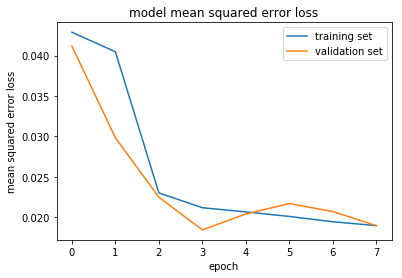

In [6]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch =len(train_samples)*6, 
                                     validation_data = validation_generator,
                                     nb_val_samples = len(validation_samples)*6, 
                                     nb_epoch=8, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [7]:
model.save('../model.h5')